# Load Data
Takes about 30 seconds.

In [1]:
import pickle
from time import time

data_file = '/content/drive/My Drive/time_sequence_alchemy/data/Xy_dataset.pkl' #  on google drive
# data_file = './data/HDFS/Xy_dataset.pkl'  # on laptop

start = time()
X, y = pickle.load(open(data_file,'rb'))
print('Time used: {:.1f}s'.format(time()-start))

X.shape, y.shape

Time used: 34.0s


((575061, 2), (575061,))

In [9]:
# count token frequency
vocab_cnt = {}
for seq in X[:,0]:
  for val in seq:
    if val in vocab_cnt.keys():
      vocab_cnt[val] += 1
    else:
      vocab_cnt[val] = 1

vocab_cnt

{'0567184d': 1464,
 '06d16156': 5,
 '09a53393': 1723232,
 '0f86472a': 2,
 '124068c6': 16,
 '13eb7010': 4,
 '234302e6': 15,
 '2e68ccc3': 5545,
 '2ecc047e': 6,
 '2f85639c': 33,
 '32777b38': 120036,
 '3d91fa85': 575061,
 '40651754': 6837,
 '4610d0f1': 9,
 '461a1574': 34,
 '506b3c4b': 19,
 '54e5f6b4': 165,
 '559305d8': 3,
 '5c88d71b': 5,
 '5d5de21c': 1719741,
 '626085d5': 428726,
 '68429f34': 9,
 '69bca6e5': 75,
 '71cf10b1': 16,
 '728076ac': 6837,
 '73c2ec69': 6937,
 '75627efd': 165,
 '78915d3a': 10,
 '81cee340': 356207,
 '8f2bc724': 1288,
 'ace40671': 67,
 'b15ffff8': 65,
 'b65fc512': 1,
 'bcc910df': 3226,
 'c294d20f': 975,
 'c61b491b': 7,
 'd013b7a3': 75,
 'd38aa58d': 1706728,
 'd63ef163': 1396174,
 'd6b7b743': 7097,
 'dba996ef': 1402047,
 'e024fa48': 11,
 'e3df2680': 1706514,
 'f0d1ff15': 22,
 'f266840a': 56,
 'f79898ae': 47,
 'fcd37a6d': 10,
 'ff00cd08': 5}

# word2vec

train the word vectors.

a good guide to training is here: https://code.google.com/archive/p/word2vec/

Parameters:
- iter: epochs of training
- sg: 1 - use skip-gram (for infrequent words), 0 use CBOW (fast).
- hs: 1 - hierarchical softmax (for infrequent words), 0 - negative sampling (for frequent words, low dimensional)
- negative: number of negative sampling.

Observation:
- This dataset has quite a number of infrequent tokens
- So using sg & hs gives embedding values in a better range (-2,2), while using CBOW gives a wider range (-5,5), which may not be good for NN training.

In [0]:
from gensim.models import Word2Vec

In [4]:
embedding_dims = 16
seq_text = X[:,0]

start = time()
model = Word2Vec(
    seq_text, size=embedding_dims, window=5, iter=5,
    sg=1, hs=1,
    seed=42, min_count=1, workers=4)

print('Time used: {:.1f}s'.format(time()-start))

Time used: 22.4s


In [0]:
import math
from matplotlib import pyplot as plt
import numpy as np

def plot_enc_2d(data:'2d array', label:'list', offset=(0,0), size=[]):
    '''Scatter plot'''
    # check input shape
    if data.shape[1] == 2: pass
    elif data.shape[0] == 2: data = data.transpose()
    else: 
      print('Data dimension error:', data.shape)
      return -1
    
    z1 = data[:,0]   # coordinate on x axis
    z2 = data[:,1]   # coordinate on y axis
    if size:
      plt.scatter(z1, z2, s=size, edgecolors='black', alpha=0.5)
    else:
      plt.scatter(z1, z2)

    # plot annotation
    for i, txt in enumerate(label):
      if size:
        scale = max(size) * 20

        plt.annotate(txt, (z1[i]+size[i]/scale+offset[0], z2[i]+offset[1]), fontsize=14)
      else:
        plt.annotate(txt, (z1[i]+offset[0], z2[i]+offset[1]), fontsize=14)

    plt.grid()


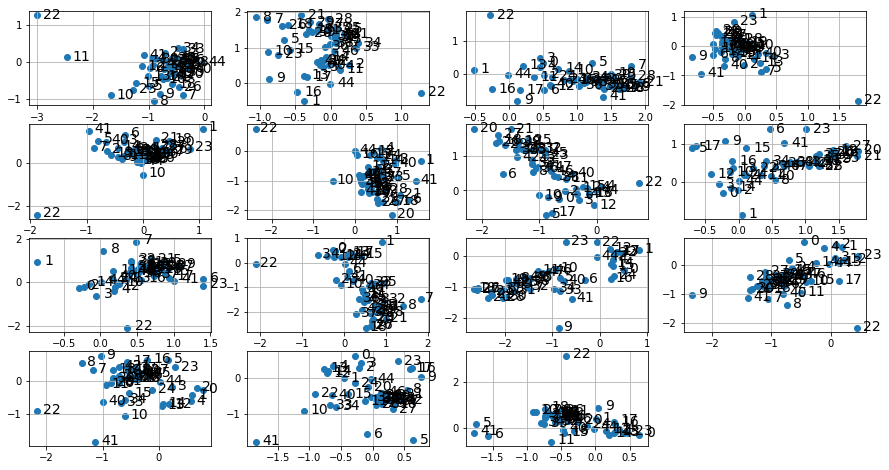

In [0]:
vocab = list(model.wv.vocab.keys())

# subplot
col = 4
row = 4
plt.figure(figsize=(15,8))
for i in range(row):
  for j in range(col):
    idx = i*col + j
    if idx >= model.wv.vector_size-1: break
    plt.subplot(row,col,idx+1)

    coord_2d = [model.wv[k][idx:idx+2].reshape(-1,1) for k in vocab]
    coord_2d = np.concatenate(coord_2d, axis=1)

    plot_enc_2d(coord_2d, range(48), offset=[0.1,0])
    # plt.xlim([-10, 10])
    # plt.ylim([-10, 10])

Pick one sample for presentation.

(-2.3, 1.2)

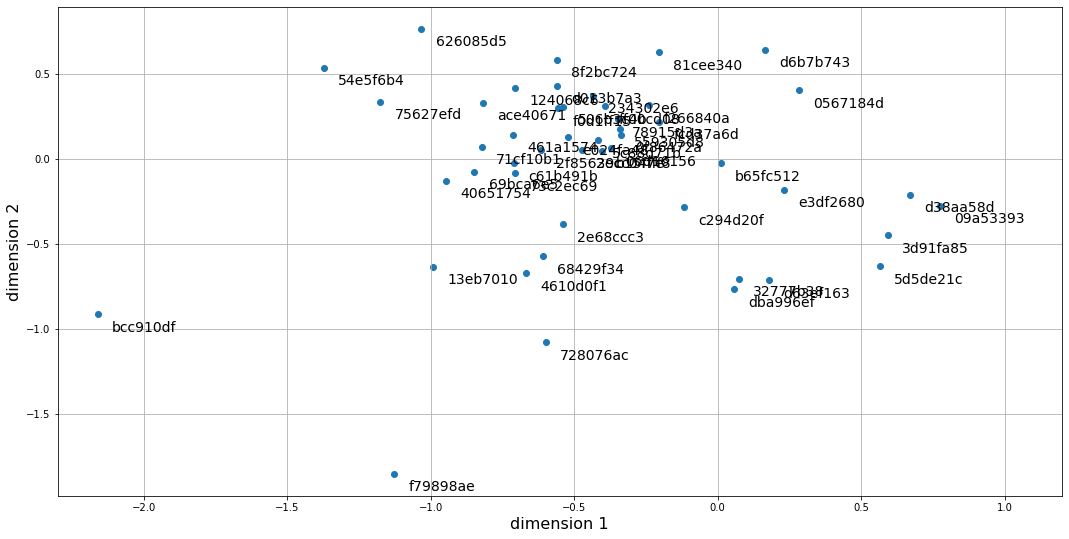

In [0]:
idx = 12
coord_2d = [model.wv[k][idx:idx+2].reshape(-1,1) for k in vocab]
coord_2d = np.concatenate(coord_2d, axis=1)

plt.figure(figsize=(18,9))
plot_enc_2d(coord_2d, vocab, offset=(0.05,0))

plt.xlabel('dimension 1', fontsize=16)
plt.ylabel('dimension 2', fontsize=16)
plt.xlim([-2.3,1.2])

# Save the embeddings

use txt file (also csv file) to save the embeddings.

In [119]:
# embedding_fn = 'log_embeddings_16.txt'
embedding_fn = '/content/drive/My Drive/time_sequence_alchemy/log_embeddings_16_sg.txt' #  on google drive
model.wv.save_word2vec_format(embedding_fn, binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [130]:
# Load embeddings
fn = '/content/drive/My Drive/time_sequence_alchemy/log_embeddings_16_sg.txt'
embeddings = load_embeddings(fn)

len(embeddings)

vocab_size, embedding_dims: 48 16


48

In [0]:
import numpy as np

def load_embeddings(filename):
  '''Load word2vec embeddings text file saved by gensim.
  Since the file is in text format, no gensim package needed.
  '''
  embeddings = {}
  vocab_size = 0
  embedding_dims = 0

  with open(filename, 'r') as f:
    # skip the first line
    vocab_size, embedding_dims = [int(v) for v in f.readline().split()]
    print('vocab_size, embedding_dims:', vocab_size, embedding_dims)

    # read every line and store as numpy array
    for line in f:
      values = line.split()
      word = values[0]
      embeddings[word] = np.array([float(v) for v in values[1:]])

  # double check
  if len(embeddings) != vocab_size:
    print('Error loading embedding file. Vocab size does not match:',
        len(embeddings), vocab_size)
  elif len(embeddings[word]) != embedding_dims:
    print('Error loading embedding file. Embedding size does not match:',
        len(embeddings[word]), embedding_dims)
    
  return embeddings

# Reproduce graph and fancier

Use loaded embeddings and vocab_cnt from Load Data section.

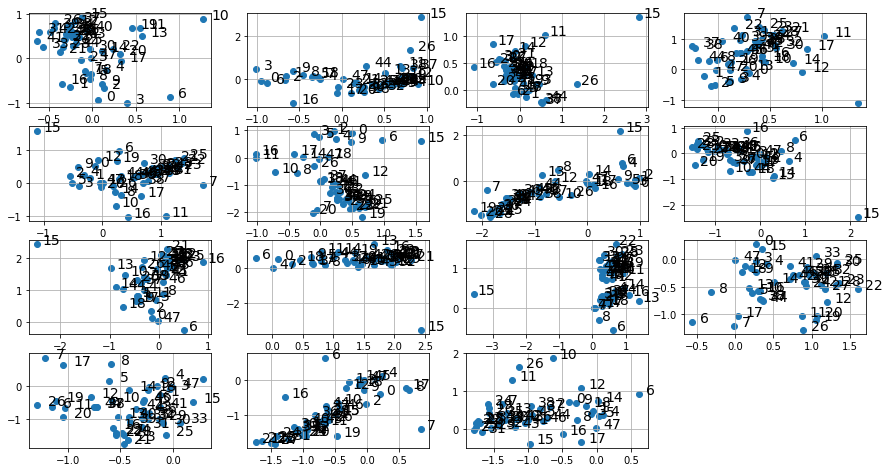

In [144]:
vocab_1 = list(embeddings.keys())
embedding_dims = len(embeddings[vocab_1[0]])

# subplot
col = 4
row = 4
plt.figure(figsize=(15,8))
for i in range(row):
  for j in range(col):
    idx = i*col + j
    if idx >= embedding_dims-1: break
    plt.subplot(row,col,idx+1)

    coord_2d = [embeddings[word][idx:idx+2].reshape(-1,1) for word in vocab_1]
    coord_2d = np.concatenate(coord_2d, axis=1)

    plot_enc_2d(coord_2d, range(48), offset=[0.1,0])
    # plt.xlim([-10, 10])
    # plt.ylim([-10, 10])

(-1.2, 1.2)

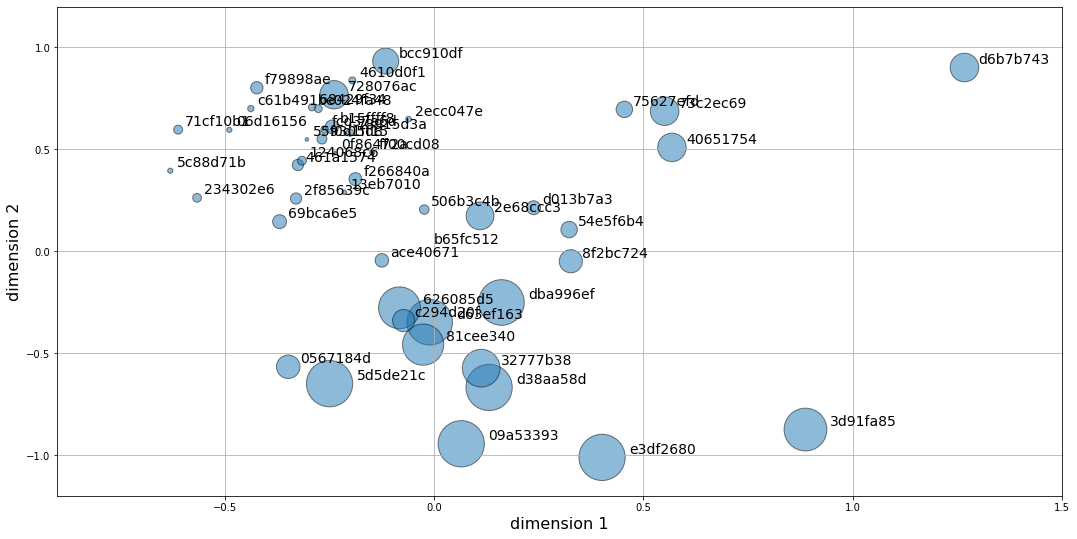

In [152]:
import math

idx = 0
vocab_1 = list(embeddings.keys())
coord_2d = [embeddings[word][idx:idx+2].reshape(-1,1) for word in vocab_1]
coord_2d = np.concatenate(coord_2d, axis=1)
size = [math.log2(vocab_cnt[word])**2*5 for word in vocab_1]

plt.figure(figsize=(18,9))
plot_enc_2d(coord_2d, vocab_1, offset=(0.015,0.02), size=size)

plt.xlabel('dimension 1', fontsize=16)
plt.ylabel('dimension 2', fontsize=16)
plt.xlim([-0.9,1.5])
plt.ylim([-1.2,1.2])